In [1]:
import os                                               #os interface library 
import requests                                         #HTTP requests library
import pandas as pd                                     #panda library
from dotenv import load_dotenv                          #dotenv library to read keys and secrect key for api
import alpaca_trade_api as trade_api                    #Alpaca library
from MCForecastTools import MCSimulation                #Monta Carlos simulation apis
import json                                             #JSON library ro work with JSON objects
from datetime import date                               #Data-Time library
import numpy as np                                      #Numpy library
from ipywidgets import *                                #Interactive Widgets library
from matplotlib import pyplot as plt                    #Map plot library

#set the backend of matplotlib to the 'inline' backend 
%matplotlib inline 


Bad key savefig.frameon in file C:\ProgramData\Anaconda3\envs\pyvizenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 421 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.4.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.level in file C:\ProgramData\Anaconda3\envs\pyvizenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 472 ('verbose.level  : silent      # one of silent, helpful, debug, debug-annoying')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.4.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.fileo in file C:\ProgramData\Anaconda3\envs\pyvizenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 473 ('verbose.fileo  : sys.stdout  # a log filename, sys.stdout or sys.stderr')
You probab

In [2]:
# Load .env enviroment variables
load_dotenv()

True

In [3]:
#Set up the alpaca trading API to retrieve data
def setting_api():
    alpaca_api_key=os.getenv("ALPACA_API_KEY")                                    #Set the Alpaca Key
    alpaca_secret_key=os.getenv("ALPACA_SECRET_KEY")                              #Set the Alpaca secret key
    alpaca = trade_api.REST(alpaca_api_key, alpaca_secret_key, api_version='v2')  #Set the REST api with URL and keys
    return alpaca                                                                 #Return the Alpaca API object


#Function for retrieving data relative to tickers/portfolio
def portfolio_data(tickers):
    today = date.today() + pd.DateOffset(years=-5)                                #Set Start date 5 years back from now                    
    today = pd.Timestamp(today, tz="America/New_York").isoformat()                #convert to ISO datetime format
    timeframe ='1Day'                                                             #Set to retrive day trade data
    portfolio =alpaca.get_bars(tickers,timeframe,start=today,adjustment='raw').df #Get the trading info based on the ticker
    portfolio.index = portfolio.index.date                                        #Set index key to date column 
    return portfolio                                                              #Return the extracted value


#function for retrieving data related to benchmark:
def bench_mark(symbol):
    bench_mark = portfolio_data(symbol)                                           #Get benchmark data from Alpaca API for giventicker
    symbol = bench_mark[['close']].rename(columns = {'close': symbol})            #Rename column from 'close' to ticker name
    return symbol                                                                 #Return the extracted value


#function to seperate the required data :
def format_data(symbol):
    ticker =portfolio[portfolio["symbol"]==symbol].drop("symbol", axis=1)         #Extract ticker based on given symbol value
    closing_price = ticker[['close']]                                             #Extract close price only for that ticker
    closing_price = closing_price.rename(columns={'close' : symbol})              #Rename the column to "close"
    return closing_price                                                          #Return the extracted value


#function for calculating cuumulative returns:
def cumulative_returns(data):
    data_returns = data.pct_change()                                             #Calculate % change for given df - data
    data_cumulative = (1 + data_returns).cumprod()                               #compute the cumulative product on %change
    return data_cumulative                                                       #Return the extracted value

# function for equally weghting stocks:
def equal_weights(data):
    weights = []                                                                #Set list variable -> weights
    for i in range(0, len(portfolio.columns)):                                  #Cal weights for each element in -> data
        w = 1 / len(portfolio.columns)
        weights.append(w)                                                       #Append calculated value to weights list
    return weights                                                              #Return the composed list


#Run the MC Simulation
def MC_simulation(Years):
    global simulation_ew
    if Years > 0:
        simulation_ew = MCSimulation(                                           #run the MC simulation
                portfolio,
                weights=equal_weights(portfolio),
                num_simulation=1000,
                num_trading_days=252*Years)
        simulation_ew.calc_cumulative_return()                                  #Calculate the cumulative return
        display(simulation_ew)                                                  #Display each cumulative return

        
#calculating confidenace level based on MC simulation
def confidence_level(Investment):
    """
    MC Simulation must be ran before executing this function
    """
    global summary_stats
    Investment = Investment.replace('$','')                                     #Remove $
    Investment = Investment.replace(',','')                                     #Remove ','
    Investment = int(Investment)                                                #Convert the value to int
    summary_stats = simulation_ew.summarize_cumulative_return()                 # summary statistics from the MC simulation results
    initial_investment = Investment                                             # Set initial investment

    # Using lower & upper CI to calculate the `95%` confidence level for chosen investment
    ci_lower = round(summary_stats[8] * initial_investment, 2)
    ci_upper = round(summary_stats[9] * initial_investment, 2)

    # Print results
    print(f"There is a 95% chance that an initial investment of ${initial_investment:,.02f} in the portfolio"
          f" over a year will end within in the range of"
          f" ${ci_lower:,.02f} and ${ci_upper:,.02f}")


In [4]:
alpaca = setting_api()                                    #Set the Alpaca API
tickers = ['APD', 'APH', 'RACE', 'TEL', 'IFF', 'GLW']     #Set tickers
portfolio = portfolio_data(tickers)                       #Rtv ticker values using Alpca API
portfolio.head()                                          #Show the retrieved value

,open,high,low,close,volume,trade_count,vwap,symbol
2017-04-17,134.78,135.8950,134.42,135.86,1092375,11416,135.497295,APD
2017-04-18,135.04,136.0200,134.72,135.27,701020,10116,135.259170,APD
2017-04-19,135.73,136.0399,134.78,134.96,577819,7170,135.166924,APD
2017-04-20,135.62,137.3400,135.20,136.90,985329,10779,136.676759,APD
2017-04-21,136.87,137.6600,136.82,137.30,1121329,9645,137.275887,APD


In [5]:
#Extract and format each ticker from df Portfolio
apd =format_data('APD')
aph =format_data('APH')
race=format_data('RACE')
tel=format_data('TEL')
iff=format_data('IFF')
glw=format_data('GLW')
glw.head()                    #Display apd df

,GLW
2017-04-17,26.54
2017-04-18,26.89
2017-04-19,26.86
2017-04-20,27.11
2017-04-21,27.02


In [6]:
spy = bench_mark('SPY')     #Get the benchmark ticker - S&P 500
spy.head()                  #View the retrieved dataframe

,SPY
2017-04-17,234.57
2017-04-18,233.87
2017-04-19,233.44
2017-04-20,235.34
2017-04-21,234.59


In [7]:
#Concatinate all the tickers into one dataframe
portfolio = pd.concat([apd, aph, race, tel, iff, glw],axis =1)
portfolio.head()       #View the concatinated df

,APD,APH,RACE,TEL,IFF,GLW
2017-04-17,135.86,69.53,71.32,72.77,133.02,26.54
2017-04-18,135.27,69.96,70.59,73.08,134.07,26.89
2017-04-19,134.96,70.12,71.26,73.18,134.53,26.86
2017-04-20,136.90,70.82,71.40,74.12,135.80,27.11
2017-04-21,137.30,70.47,70.82,73.61,136.12,27.02


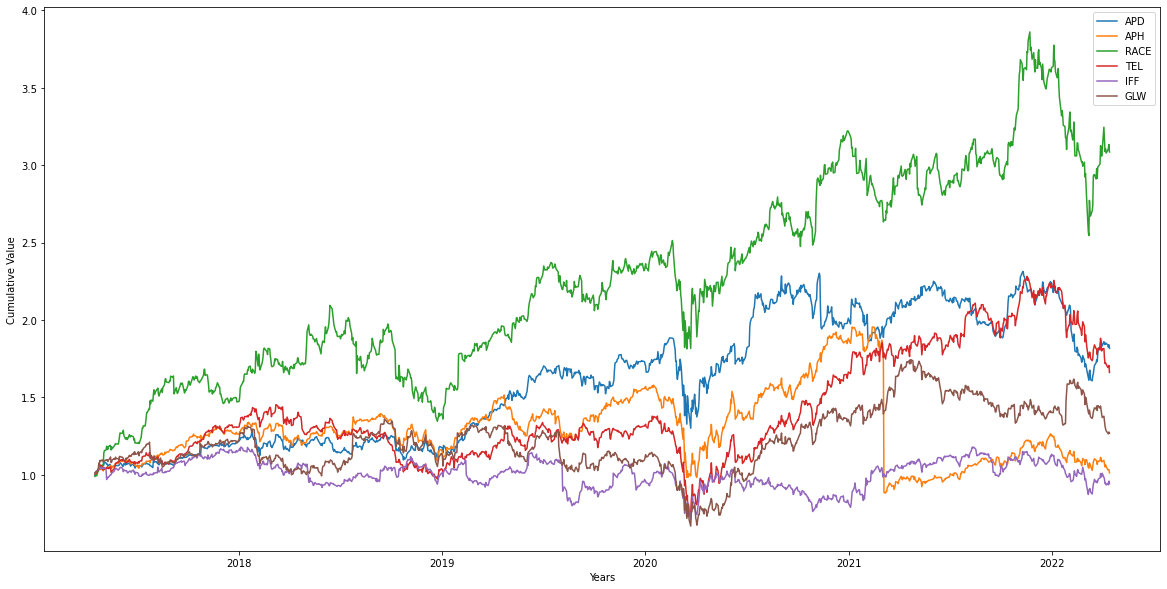

In [8]:
portfolio_cumulative = cumulative_returns(portfolio)       #Calculate cumulative returns for stock portfolio
portfolio_cumulative.dropna(inplace=True)                  #Drop all na values
portfolio_cumulative.plot(figsize = (20,10), kind="line", ylabel='Cumulative Value', xlabel='Years')  #Plot line graph on portfolio
plt.savefig('Images/Portfolio Cumulative.png', bbox_inches='tight')    #Save the graph

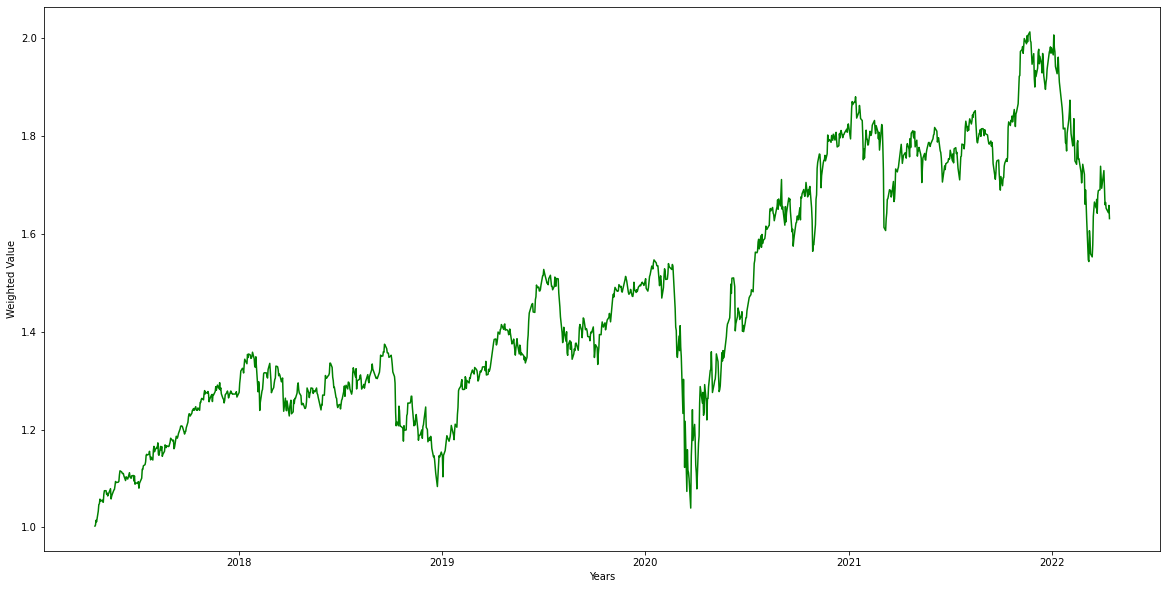

In [9]:
weights = equal_weights(portfolio)                                #Calculate the equal weighted value for each ticker
portfolio_price_action = portfolio_cumulative.dot(weights)        #Get the cumulative product by weights for each tickers

#Plot line graph
portfolio_price_action.plot(figsize = (20,10), kind="line", ylabel='Weighted Value', xlabel='Years', color='g')  
plt.savefig('Images/portfolio_price_action', bbox_inches='tight')    #Save the graph

In [10]:
spy_cumulative = cumulative_returns(spy)                                                             #Get cumulative return ffor benchmark
comparison = pd.concat([portfolio_price_action,spy_cumulative],axis = 1 ,join = 'inner').dropna()    #Concat both df
comparison = comparison.rename(columns = {0:'E.W Portfolio'})                                        #Give a column name

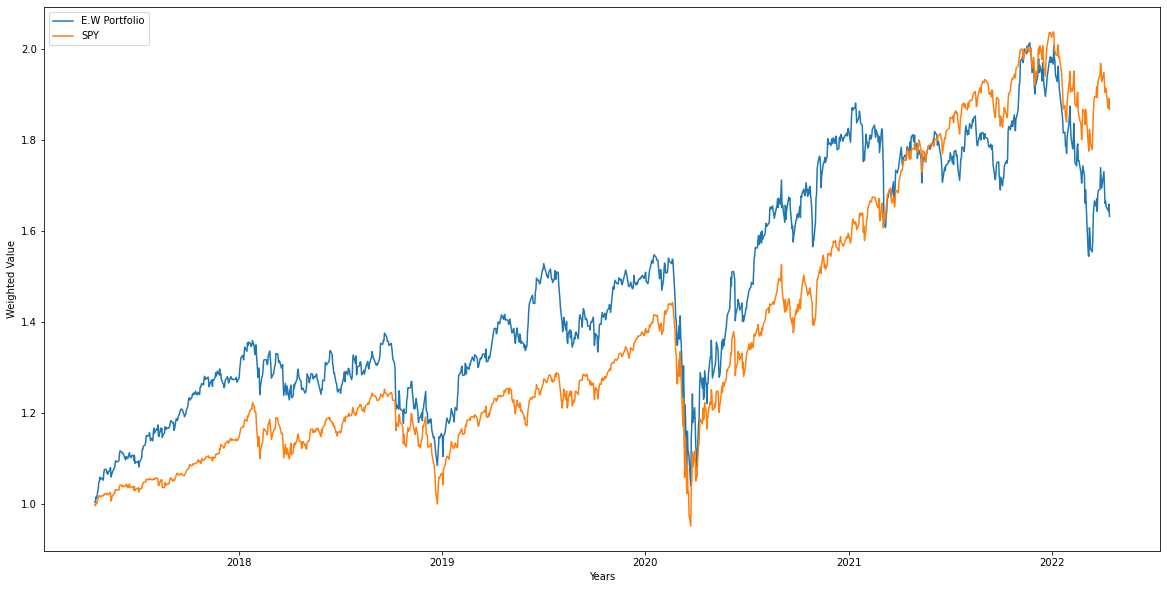

In [11]:
#Plot the comparison data
comparison.plot(figsize = (20,10), kind="line", ylabel='Weighted Value', xlabel='Years')
plt.savefig('Images/Comparison Plot.png', bbox_inches='tight')    #Save the graph

In [12]:
#Rename column to close since Mc requires column name "close"
apd = apd.rename(columns={'APD' : 'close'})
aph = aph.rename(columns={'APH' : 'close'})
race = race.rename(columns={'RACE' : 'close'})
tel = tel.rename(columns={'TEL' : 'close'})
iff = iff.rename(columns={'IFF' : 'close'})
glw = glw.rename(columns={'GLW' : 'close'})
portfolio = pd.concat([apd,aph,race,tel,iff,glw],axis =1,keys = ['APD','APH','RACE','TEL','IFF','GLW'])

#Alow user to chioose the number of trading days for MC simulation 
heading = widgets.Label('Choose your trading years')   #Set the widget heading
display(heading)                                       #Display the heading
interactive(MC_simulation, Years=([1, 3, 5]))          #Show the dropdown box


Label(value='Choose your trading years')

interactive(children=(Dropdown(description='Years', options=(1, 3, 5), value=1), Output()), _dom_classes=('wid…

In [13]:
#Display simulated returns from MC
simulation_ew.simulated_return

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.997961,1.014489,0.991276,1.001680,0.993838,0.994123,1.004157,1.008312,0.995976,1.002903,...,0.990998,0.996092,0.995719,1.009383,0.999141,1.012850,0.997136,1.008193,1.008266,1.001351
2,1.015866,1.003193,1.001060,0.989808,1.004103,0.982369,0.997278,1.007589,0.985218,0.997950,...,0.988341,0.995399,1.001404,1.004215,1.003580,1.028866,0.981946,1.014461,1.003277,1.009310
3,1.040044,1.008841,0.988511,0.985257,1.006551,0.993284,0.996746,1.013233,0.991792,0.995940,...,0.987799,1.002344,1.006983,1.012993,1.005204,1.037544,0.996194,1.015141,1.005665,0.997024
4,1.045029,1.000010,0.986679,0.975116,1.013877,0.999683,1.003254,1.024828,0.999993,1.011394,...,0.982889,1.004853,1.015347,1.011547,1.008175,1.028140,1.014099,1.004994,1.001251,1.015731
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,1.515808,1.028912,1.112756,1.036287,0.907481,1.233241,1.118735,1.073476,0.937053,1.127883,...,1.086552,1.090800,1.197048,1.269746,0.967649,1.084894,1.139543,1.197152,1.563316,1.530994
249,1.538674,1.042613,1.124159,1.038468,0.904216,1.232065,1.118722,1.077026,0.933377,1.141100,...,1.080237,1.094706,1.186734,1.281915,0.977596,1.084194,1.129282,1.206559,1.553135,1.534567
250,1.545207,1.048126,1.127830,1.048279,0.903221,1.243730,1.122880,1.081967,0.920441,1.134634,...,1.077548,1.101250,1.176010,1.269843,0.978088,1.082641,1.132154,1.211749,1.556095,1.533597
251,1.552079,1.040572,1.132560,1.047671,0.883519,1.247161,1.137076,1.081876,0.917489,1.126729,...,1.094909,1.112378,1.170770,1.274418,0.976337,1.075321,1.143601,1.193015,1.563826,1.532583


<AxesSubplot:title={'center':'1000 Simulations of Cumulative Portfolio Return Trajectories Over the Next 252 Trading Days.'}>

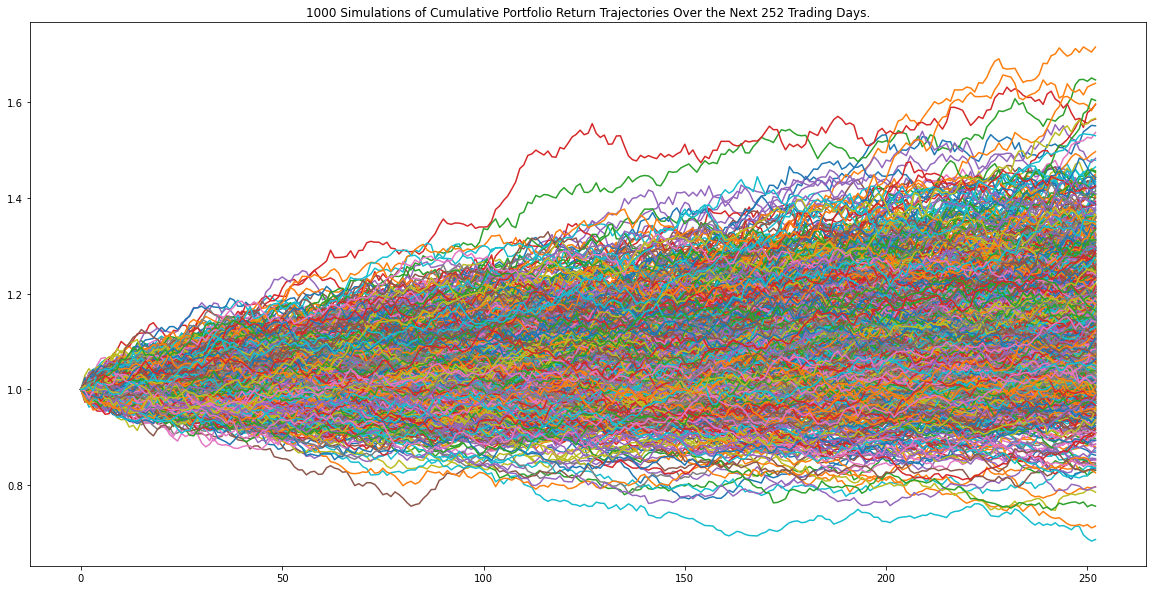

In [14]:
#Plot the MC simulation 
simulation_ew.plot_simulation()

In [15]:
#Allow user to choose their initial investment amount to calculate predited amount
#at 95% confidence level
heading = widgets.Label('Choose your initial investment')
display(heading)
interactive(confidence_level, Investment=['$5,000', '$10,000', '$15,000'], value=None)

Label(value='Choose your initial investment')

interactive(children=(Dropdown(description='Investment', options=('$5,000', '$10,000', '$15,000'), value='$5,0…

In [16]:
# Calculate volatility based on the MC stats
volatility = round(summary_stats[2] * np.sqrt(252) )        #Calculate the volatility
volatility                                                  #Display the values

2

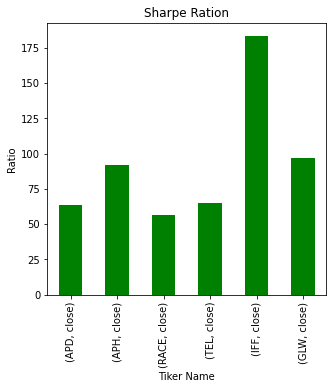

In [17]:
# Annualized Sharpe Ratios
annualized_sharpe_ratio = (portfolio.mean()* 252) / (portfolio.std() * np.sqrt(252))

# Visualize the sharpe ratios as a bar plot
annualized_sharpe_ratio.plot(kind = "bar", title = "Sharpe Ration", figsize = (5,5), ylabel="Ratio", xlabel="Tiker Name", color='g')
plt.savefig('Images/Sharpe Ratio.png', bbox_inches='tight')                   #Save the graph

In [18]:
from IPython.display import clear_output
import panel as pn
from panel.interact import interact
pn.extension()



Running Monte Carlo simulation number 90.


Running Monte Carlo simulation number 0. 
Running Monte Carlo simulation number 10. 
Running Monte Carlo simulation number 20. 
Running Monte Carlo simulation number 30. 
Running Monte Carlo simulation number 40. 
Running Monte Carlo simulation number 50. 
Running Monte Carlo simulation number 60. 
Running Monte Carlo simulation number 70. 
Running Monte Carlo simulation number 80. 
Running Monte Carlo simulation number 90.

Row
    [0] Column
        [0] Markdown(str)
        [1] Column
            [0] Select(name='Choose your t..., options=[1, 3, 5], value=1)
        [2] ParamFunction(function)
    [1] Spacer(width=50)

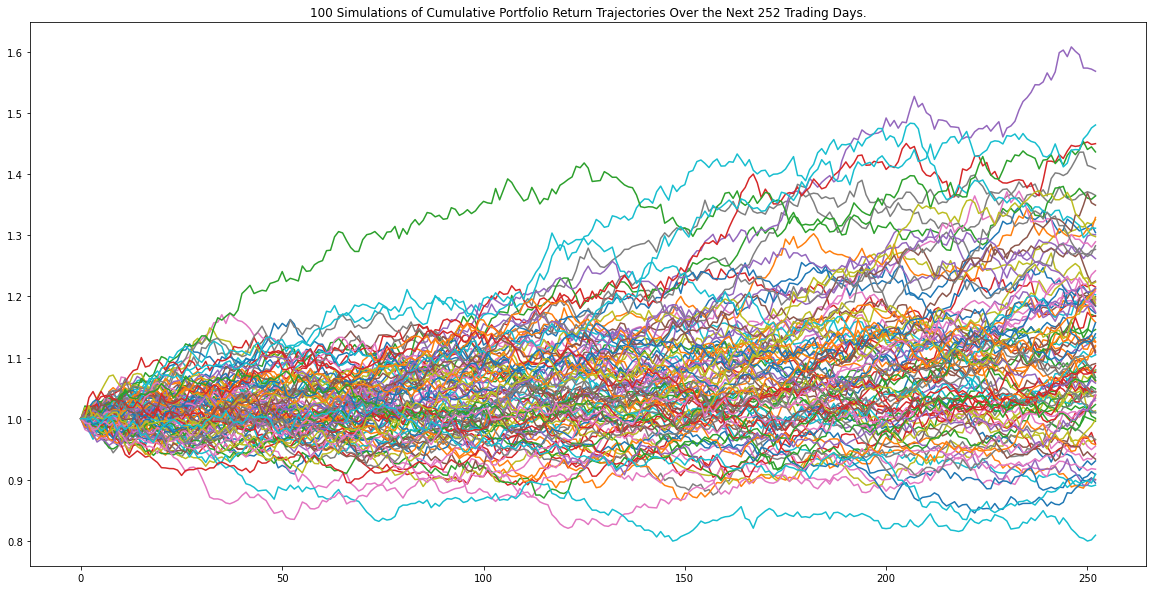

In [37]:
year = pn.widgets.Select(name='Choose your trajectories years', options=[1, 3, 5], value=1)
out = widgets.Output(layout={'border': '0.1px solid black', 'width': '1200px'})

@pn.depends(year)
def mc_sim(x):
    simulation_ew1 = MCSimulation(                                           #run the MC simulation
                     portfolio,
                     weights=equal_weights(portfolio),
                     num_simulation=100,
                     num_trading_days=252*x)
    out.clear_output()
    t = simulation_ew1.calc_cumulative_return()                                  #Calculate the cumulative return
    p = simulation_ew1.plot_simulation()
    with out:
        display(t)
        display(p)
    return out

        
pn.Row(
       pn.Column('## MC Simulation', 
                pn.Column(year),
                mc_sim),                                
       pn.Spacer(width=50))


In [33]:
p

<AxesSubplot:title={'center':'1000 Simulations of Cumulative Portfolio Return Trajectories Over the Next 252 Trading Days.'}>